In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import timm
import random

In [3]:
transform_1 = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [4]:
transform_2 = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),              
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),      
    transforms.RandomAffine(degrees=0, shear=10),  
    transforms.ToTensor(),
])

In [5]:
transform_3 = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(5),              
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),  
    transforms.RandomAffine(degrees=5, scale=(0.9, 1.1)),      
    transforms.RandomAffine(degrees=5, shear=10),  
    transforms.ToTensor(),
])

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        
        if self.labels is not None:
            label = self.labels[idx]
        else:
            label = None
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label) if label is not None else image

In [8]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [9]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")


y = train_data['label'].values
X = train_data.drop('label', axis=1).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


X_train /= 255.0
X_val /= 255.0


X_train = X_train.repeat(1, 3, 1, 1)
X_val = X_val.repeat(1, 3, 1, 1)

train_dataset_1 = MNISTDataset(X_train, y_train, transform=transform_1)
train_dataset_2 = MNISTDataset(X_train, y_train, transform=transform_2)
train_dataset_3 = MNISTDataset(X_train, y_train, transform=transform_3)

val_dataset_1 = MNISTDataset(X_val, y_val, transform=transform_1)
val_dataset_2 = MNISTDataset(X_val, y_val, transform=transform_2)
val_dataset_3 = MNISTDataset(X_val, y_val, transform=transform_3)


train_dataset = train_dataset_1+train_dataset_2+train_dataset_3
val_dataset = val_dataset_1+val_dataset_2+val_dataset_3

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
model = models.resnet50(weights='DEFAULT')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.1, verbose=True, min_lr=0.0001)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

In [12]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
count_parameters(model)

23528522

In [14]:
num_epochs = 50
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_loss = None

In [15]:
%%time

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (data, target) in enumerate(train_loop):
        # data = data.view(data.size(0), -1).to(device)
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            # data = data.view(data.size(0), -1).to(device)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    lr = scheduler.get_last_lr()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, lr = {lr}')

    if best_loss is None:
      best_loss = val_loss

    if val_loss < best_loss:
      best_loss = val_loss

      print(f'Min best loss: {best_loss:.4f}', end='\n\n')

    early_stopping(val_loss)
    if early_stopping.early_stop:
      print('Early stopping')
      break

Epoch 1/50: 100%|██████████| 1575/1575 [01:51<00:00, 14.14it/s]


Epoch [1/50], Train Loss: 0.2227, Train Acc: 93.51%, Val Loss: 0.0457, Val Acc: 98.69%, lr = [0.01]


Epoch 2/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.05it/s]


Epoch [2/50], Train Loss: 0.0468, Train Acc: 98.68%, Val Loss: 0.0310, Val Acc: 99.05%, lr = [0.01]
Min best loss: 0.0310



Epoch 3/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.01it/s]


Epoch [3/50], Train Loss: 0.0348, Train Acc: 99.00%, Val Loss: 0.0319, Val Acc: 99.02%, lr = [0.01]


Epoch 4/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.03it/s]


Epoch [4/50], Train Loss: 0.0270, Train Acc: 99.21%, Val Loss: 0.0294, Val Acc: 99.10%, lr = [0.01]
Min best loss: 0.0294



Epoch 5/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.00it/s]


Epoch [5/50], Train Loss: 0.0237, Train Acc: 99.31%, Val Loss: 0.0309, Val Acc: 99.00%, lr = [0.001]


Epoch 6/50: 100%|██████████| 1575/1575 [01:52<00:00, 13.98it/s]


Epoch [6/50], Train Loss: 0.0168, Train Acc: 99.51%, Val Loss: 0.0218, Val Acc: 99.32%, lr = [0.001]
Min best loss: 0.0218



Epoch 7/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.00it/s]


Epoch [7/50], Train Loss: 0.0140, Train Acc: 99.59%, Val Loss: 0.0204, Val Acc: 99.37%, lr = [0.001]
Min best loss: 0.0204



Epoch 8/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.02it/s]


Epoch [8/50], Train Loss: 0.0136, Train Acc: 99.61%, Val Loss: 0.0196, Val Acc: 99.38%, lr = [0.001]
Min best loss: 0.0196



Epoch 9/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.04it/s]


Epoch [9/50], Train Loss: 0.0127, Train Acc: 99.62%, Val Loss: 0.0183, Val Acc: 99.46%, lr = [0.0001]
Min best loss: 0.0183



Epoch 10/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.02it/s]


Epoch [10/50], Train Loss: 0.0127, Train Acc: 99.63%, Val Loss: 0.0192, Val Acc: 99.39%, lr = [0.0001]


Epoch 11/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.01it/s]


Epoch [11/50], Train Loss: 0.0128, Train Acc: 99.63%, Val Loss: 0.0195, Val Acc: 99.42%, lr = [0.0001]


Epoch 12/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.00it/s]


Epoch [12/50], Train Loss: 0.0125, Train Acc: 99.63%, Val Loss: 0.0203, Val Acc: 99.37%, lr = [0.0001]


Epoch 13/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.04it/s]


Epoch [13/50], Train Loss: 0.0122, Train Acc: 99.63%, Val Loss: 0.0207, Val Acc: 99.35%, lr = [0.0001]


Epoch 14/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.01it/s]


Epoch [14/50], Train Loss: 0.0126, Train Acc: 99.63%, Val Loss: 0.0192, Val Acc: 99.40%, lr = [0.0001]


Epoch 15/50: 100%|██████████| 1575/1575 [01:52<00:00, 13.98it/s]


Epoch [15/50], Train Loss: 0.0113, Train Acc: 99.66%, Val Loss: 0.0191, Val Acc: 99.37%, lr = [0.0001]


Epoch 16/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.00it/s]


Epoch [16/50], Train Loss: 0.0122, Train Acc: 99.65%, Val Loss: 0.0190, Val Acc: 99.40%, lr = [0.0001]


Epoch 17/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.02it/s]


Epoch [17/50], Train Loss: 0.0117, Train Acc: 99.65%, Val Loss: 0.0181, Val Acc: 99.44%, lr = [0.0001]
Min best loss: 0.0181



Epoch 18/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.02it/s]


Epoch [18/50], Train Loss: 0.0122, Train Acc: 99.63%, Val Loss: 0.0189, Val Acc: 99.39%, lr = [0.0001]


Epoch 19/50: 100%|██████████| 1575/1575 [01:52<00:00, 14.01it/s]


Epoch [19/50], Train Loss: 0.0112, Train Acc: 99.67%, Val Loss: 0.0187, Val Acc: 99.43%, lr = [0.0001]
Early stopping
CPU times: user 41min 11s, sys: 7.24 s, total: 41min 18s
Wall time: 41min 9s


Text(0.5, 1.0, 'Training and Validation Loss')

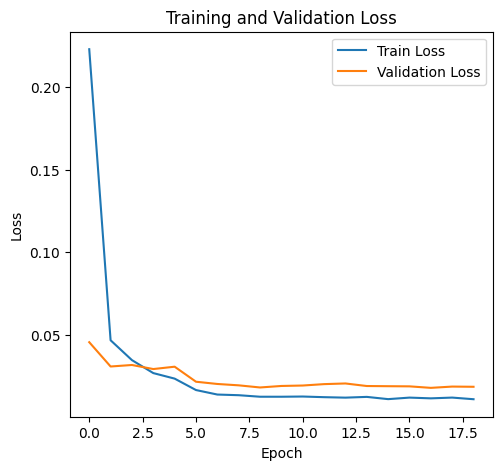

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

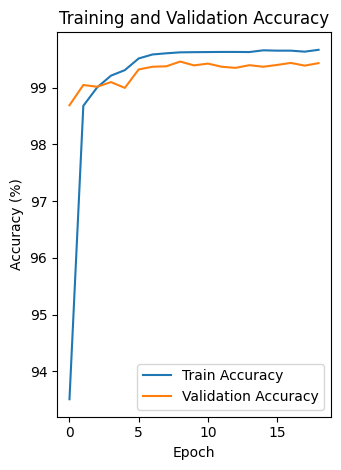

In [17]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [18]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X_test = torch.tensor(test_data.values, dtype=torch.float32).view(-1, 1, 28, 28)

X_test /= 255.0

X_test = X_test.repeat(1, 3, 1, 1)

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()

predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data[0].to(device)
        
        
        output = torch.softmax(model(data), dim=1)

        _, predicted = torch.max(output.data, 1)
        predictions.extend(predicted.cpu().numpy())

print(f"Total predictions: {len(predictions)}")

submission_df = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

print(submission_df.head())

submission_df.to_csv('submission.csv', index=False)

Total predictions: 28000
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
